## imports

In [1]:
%matplotlib inline
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import sqlite3
import numpy as np
from lsst.sims.maf.metrics.snSNRMetric import SNSNRMetric
from lsst.sims.maf.utils.snUtils import Reference_Data

## DB file choice

In [2]:
dbName = 'kraken_2026.db'
dbFile = dbName #'/home/philippe/LSST/DB_Files/{}'.format(dbName)
opsimdb = db.OpsimDatabase(dbFile)
version = opsimdb.opsimVersion
propinfo, proptags = opsimdb.fetchPropInfo()
print('proptags and propinfo', proptags, propinfo)
runLength = opsimdb.fetchRunLength()

proptags and propinfo {'WFD': [3], 'DD': [5], 'NES': [4]} {1: 'GalacticPlane', 2: 'SouthCelestialPole', 3: 'WideFastDeep', 4: 'NorthEclipticSpur', 5: 'DeepDrillingCosmology1'}


## Field choice (DD or WFD)

In [3]:
fieldtype='WFD' #fieldtype: DD or WFD

sqlconstraint = '' #opsimdb.createSQLWhere(fieldtype, proptags)


if fieldtype == 'DD':
    coadd = True
    fracmin = 0.05
    fracmax = 1.0
if fieldtype == 'WFD':
    coadd = False
    fracmin = 0.05
    fracmax = 1.0
    
Li_files = ['../../data/Li_SNCosmo_-2.0_0.2.npy']
mag_to_flux_files = ['../../data/Mag_to_Flux_SNCosmo.npy']
names_ref = ['SNCosmo']
config_fake = '../../data/Fake_cadence.yaml'

In [4]:
bands = 'r'
z=0.3

plotDict = {'title': 'Redshift limit',
                'xlabel': 'Detection rate','xMin':fracmin,'xMax':fracmax,'nTicks':10,
           'colorMin': fracmin,'colorMax':fracmax}

plotDict['bins'] = np.arange(0.,0.5,0.05)

# Load sn lc info and mags
lim_sn = {}
for band in bands:
    lim_sn[band] = Reference_Data(
                Li_files,mag_to_flux_files,band, z)


## Define slicer

In [5]:
from lsst.sims.utils import equatorialFromGalactic
names = ['ra', 'dec']
# Number of objects to create
nobjs = int(1e3)  #  Note, we are going to loop over each object, so try not to make this a crazy huge number. 
# An empty numpy array that will hold the catalog of transient objects
transObjects = np.zeros(nobjs, dtype=list(zip(names, [float]*len(names))))
# Concentrate objects in the galactic plane
l = np.random.rand(nobjs)*360.
b = np.random.randn(nobjs)*20.
transObjects['ra'], transObjects['dec'] = equatorialFromGalactic(l,b)
# Set up the slicer to evaluate the catalog we just made
# XXX--ugh, because the old V3 OpSim runs store things in radians, need to set latLonDeg kwarg. 
#slicer = slicers.UserPointsSlicer(transObjects['ra'], transObjects['dec'], latLonDeg=True)
#if fieldtype == 'DD':
slicer = slicers.HealpixSlicer(nside=64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## Make the bundle

In [6]:
bundleList= []
yearDates = list(range(0, int(round(365 * runLength)) + 365, 365))

for band in bands: #Loop on the bands
    sql_i = '' #sqlconstraint+' AND '
    sql_i += 'filter = "%s"' % (band) #sql constraint on the band
    
    for season in range(1,2):
        metric = SNSNRMetric(lim_sn=lim_sn[band], coadd=coadd, names_ref=names_ref,
                             season=season,z=0.3,config_fake=config_fake)

        plotDict['title'] = 'season {} - {} band - z={}'.format(season,band,z)
            
        sql_y = sql_i + ' AND night > %i AND night <= %i' % (
                    yearDates[np.max([0,season-2])], yearDates[np.min([9,season + 2])]) #sql constraint on the year   
        bundleList.append(metricBundles.MetricBundle(
            metric, slicer, sql_y, runName= '{}_{}'.format(dbName,season),plotDict=plotDict))
print(len(bundleList))

1


## Run 

In [7]:
outDir = '{}_Cadence'.format(dbName)
resultsDb = db.ResultsDb(outDir=outDir)
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsimdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with constraint filter = "r" AND night > 0 AND night <= 1095 for columns ['observationId', 'visitTime', 'observationStartMJD', 'filter', 'fieldDec', 'fiveSigmaDepth', 'fieldRA', 'numExposures', 'visitExposureTime', 'night']
Found 153277 visits
Running:  ['kraken_2026_db_1_SNSNRMetric_r_AND_night_gt_0_AND_night_lt_1095_HEAL']


/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:5555: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  self[...] = self[idx]


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


## Plot the results

Plotting figures with "filter = "r" AND night > 0 AND night <= 1095" constraint now.
monopole: 0.30441  dipole: lon: 152.219, lat: 0.72553, amp: 0.0442992
Plotting complete.


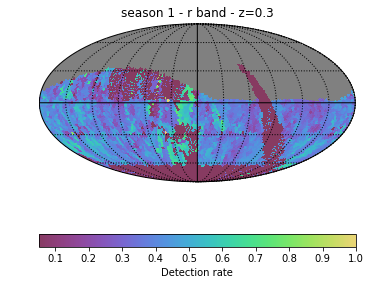

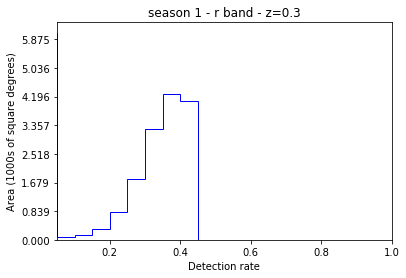

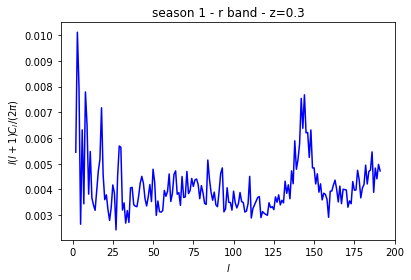

In [8]:
bgroup.plotAll(closefigs=False)